# Geographically Weighted Regression

In this notebook, we will use Geographically Weighted Regression to predict zoonoses.
GWR is a spatial statistical technique that captures process’s spatial heterogeneity.

In [1]:
import pyarrow.feather as feather
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gp
from urllib.request import urlopen
import json
import numpy as np
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from spglm.family import Gaussian, Binomial, Poisson
from shapely.geometry import Point
from numpy import savetxt
import warnings

bounding_box_km_offset = 2.5
df_feather_prefix = 'dataframe_sigla'

region_code_dict = {'01':'Piemonte',
                    '02':'VDA',
                    '07':'Liguria'}

#ATTENZIONE! ora i dataset xxxGWR sono stati rigenerati senza duplicati per fare una prova per la salmonella che dà problemi
datasets={#'Leishmaniasis':feather.read_feather('SiIsCover_LeishmaniasisGWR')#,
            #'Leptospirosis':feather.read_feather('SiIsCover_LeptospirosisGWR'),
            #'Hepatitis':feather.read_feather('SiIsCover_HepatitisGWR'),
            'Salmonellosis':feather.read_feather('SiIsCover_SalmonellosisGWR') #'SiIsCover_SalmonellosisGWR' #file with GWR inside name are without any duplicate on lat long
            }

features_columns=['Superficie', 'Popolazione','altitudine','Superfici_artificiali_e_costruzioni_ha',
                           'Superfici_naturali_non_vegetate_ha', 'Alberi_ha', 'Arbusti_ha',
                           'Vegetazione_erbacea_ha', 'Acque_e_zone_umide_ha',
                           'Superfici_artificiali_e_costruzioni_%','Superfici_naturali_non_vegetate_%', 
                           'Alberi_%', 'Arbusti_%','Vegetazione_erbacea_%', 'Acque_e_zone_umide_%',
                           'min_dist', 'count_water_sources'
                            ]

coord_columns=['latitude','longitude']
target_regions = ['01'] #07 codice ISTAT Liguria

In [2]:
def get_prov_by_region(df, region):        
    prov = pd.read_csv('province.CSV',sep=';', encoding = 'utf8')
    selected_prov = prov.loc[prov['REGIONE'] == region, 'SIGLA']
    prov_list = []
    
    for p in selected_prov:
        prov_list.append(p)
    
    towns = pd.read_csv('SIGLA_TAB_COMUNI_31052021 edit.csv',sep=';', encoding = 'utf8')
    selected_istat_code = towns[towns['provincia'].isin(prov_list)]
    prov_list_istat_codes = []
    
    for index, row in selected_istat_code.iterrows():
        prov_list_istat_codes.append(str(row['cod istat']))
    
    df_subset = df[df['COD_ISTAT_COMUNE_PRELIEVO'].isin(prov_list_istat_codes)]
    
    return df_subset

Check content of rows duplicated on latitude and longitude

In [3]:
for disease_label in datasets.keys():
    # Find a duplicate rows
    current_ds = datasets[disease_label]
    duplicateDFRow = current_ds[current_ds.duplicated(subset=['latitude', 'longitude'],keep=False)]
    print(duplicateDFRow[['latitude','longitude']].head(5))
    dup_rows_num = len(duplicateDFRow)
    df_tot_rows = len(current_ds)
    remains_rows_num = df_tot_rows - dup_rows_num
    print("Found in " + disease_label + " " + str(dup_rows_num) + " duplicated rows on latitude and longitude")
    print("Current region Tot rows for " + disease_label + ": " + str(df_tot_rows))
    print("So after remove duplicated remains AT LEAST: " + str(remains_rows_num) + " rows\n")
    test1 = current_ds.loc[(np.isclose(current_ds['latitude'], 44.216910,rtol=.0000001)) & (np.isclose(current_ds['longitude'], 8.326127,rtol=.0000001))]
    print(test1)

Empty DataFrame
Columns: [latitude, longitude]
Index: []
Found in Salmonellosis 0 duplicated rows on latitude and longitude
Current region Tot rows for Salmonellosis: 10013
So after remove duplicated remains AT LEAST: 10013 rows

Empty DataFrame
Columns: [COD_ISTAT_COMUNE_PRELIEVO, Superficie, Popolazione, altitudine, Superfici_artificiali_e_costruzioni_ha, Superfici_naturali_non_vegetate_ha, Alberi_ha, Arbusti_ha, Vegetazione_erbacea_ha, Acque_e_zone_umide_ha, Superfici_artificiali_e_costruzioni_%, Superfici_naturali_non_vegetate_%, Alberi_%, Arbusti_%, Vegetazione_erbacea_%, Acque_e_zone_umide_%, min_dist, count_water_sources, latitude, longitude, ESITO]
Index: []

[0 rows x 21 columns]


Plot region with municipalities boundaries

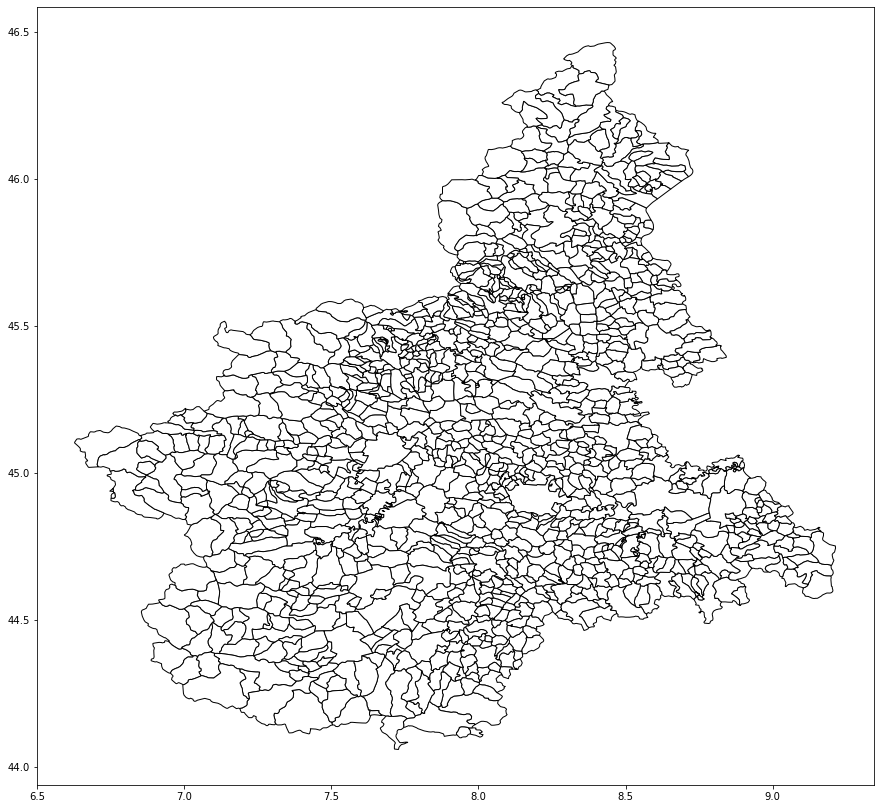

In [4]:
with urlopen('https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_municipalities.geojson') as response:
    limits_IT_municipalities = json.load(response)

gdf_IT_municipalities = gp.GeoDataFrame.from_features(limits_IT_municipalities['features'])
#print(gdf_IT_municipalities[gdf_IT_municipalities['reg_istat_code'] == '07'])
for region in target_regions:
    #reduce by region
    gdf_region_municipalities = gdf_IT_municipalities[gdf_IT_municipalities['reg_istat_code'].isin(target_regions)]

    fig, ax = plt.subplots(figsize = (15, 15))
    gdf_region_municipalities.plot(ax=ax, **{'edgecolor': 'black', 'facecolor': 'white'})
    #gdf_IT_municipalities.centroid.plot(ax = ax, c = 'blue')
    plt.savefig('graphics/' + region_code_dict[region] + '_shp')
    plt.show()
    

Set input for model

In [5]:
dfs_x_model={}
use_subset = False #this is for test. For run model with subset of data
use_single_region = True
fraction = 7


for disease_label, df in datasets.items():
    print('Rows num of dataset ' + disease_label + ' ' +  str(len(df)))
    df_with_lat_long = df[~df['longitude'].isna()]
    print('Rows num after remove none longitude ' + str(len(df_with_lat_long)))
    
    if use_single_region:
        df_with_lat_long = get_prov_by_region(df_with_lat_long, region_code_dict[region])
        print('Rows num for region ' + region_code_dict[region] + ': ' + str(len(df_with_lat_long)))
        #df_with_lat_long.plot(ax = ax, markersize = 10, **{'edgecolor': 'black','facecolor': 'black'}) 
        #plt.show()  
    
    if use_subset:
        len_df = len(df_with_lat_long)
        part = len_df/fraction
        df_with_lat_long = df_with_lat_long.head(int(part))
        print('Rows num after obtain subset ' + str(len(df_with_lat_long)))
        
    dfs_x_model[disease_label]=df_with_lat_long[features_columns+coord_columns+['ESITO']]
    #inds = np.where(df_with_lat_long['longitude'].isna())[0]
    #print(len(inds))

with warnings.catch_warnings(record=True):        
    for disease_label, df in dfs_x_model.items():  
        for col in df.columns[0:20]:
            #manage missing values
            df[col]=df[col].fillna(0)
        dfs_x_model[disease_label]=df

Rows num of dataset Salmonellosis 10013
Rows num after remove none longitude 10013
Rows num for region Piemonte: 7787


Generate Training and Test set

In [6]:
from sklearn.model_selection import train_test_split

# Extract the features and the labels
train_test_dfs={}
summary_tbl_test_train=pd.DataFrame(columns=['Dataset','Train', 'Test'])

#whether to use or not next balancing techniques
# None, 'manual1timePinflation', RandomOverSampler, SMOTE
data_balancing= None#'autoMoretimesPinflation'
original_clr=[]
inflated_clr=[]

for disease_label, df in dfs_x_model.items():
    original_clr.append([disease_label, len(df[df['ESITO']==0]), len(df[df['ESITO']==1])])
    
    #special case of inflation a priori
    if data_balancing in ['manual1timePinflation', 'autoMoretimesPinflation']:
        if data_balancing=='manual1timePinflation':
            # inflaction of Positive class
            df=df.append(df[df['ESITO']==1])
        if data_balancing=='autoMoretimesPinflation':
            clr= len(df[df['ESITO']==1])/len(df)*100
            if clr != 0:
                positive_rows=df[df['ESITO']==1]
                for i in range( int(100/clr)-1):  
                    if (len(df[df['ESITO']==1])/len(df)*100)<100:
                        previous=df.copy()
                        df=df.append(positive_rows)
                df=previous
        inflated_clr.append([disease_label, len(df[df['ESITO']==0]), len(df[df['ESITO']==1])])


    features = df.drop(columns='ESITO')
    target = df['ESITO']
    train_test_data={'X_train': None, 'X_test': None, 'y_train': None, 'y_test':None}
    # Split into training and testing
    

    X_train, X_test, y_train, y_test = train_test_split(features, 
                                                target, 
                                                test_size=0.2, 
                                                random_state = 50)
    train_test_data['X_train']= X_train
    train_test_data['X_test']=X_test
    train_test_data['y_train']= y_train
    train_test_data['y_test'] =y_test
    train_test_dfs[disease_label]=train_test_data
    

    summary_tbl_test_train=summary_tbl_test_train.append(pd.DataFrame([[disease_label, 
                                                                        X_train.shape[0],
                                                                        X_test.shape[0]]],
                                                                    columns=['Dataset',
                                                                                'Train', 
                                                                                'Test'] ))

df_original_clr=pd.DataFrame(original_clr, columns = ['zoonoose', 'Neg', 'Pos']) 
df_original_clr['Tot']=df_original_clr['Neg']+df_original_clr['Pos']
df_original_clr['clr']=df_original_clr['Pos']/df_original_clr['Neg']
df_original_clr=df_original_clr.style.format({
        'clr': '{:,.2%}'.format,
    })
df_original_clr=df_original_clr.set_caption("Original")

# in case of artificial inflation print here the result 
if data_balancing in ['manual1timePinflation', 'autoMoretimesPinflation']:
    inflated_clr=pd.DataFrame(inflated_clr, columns = ['zoonoose', 'Neg', 'Pos']) 
    inflated_clr['Tot']=inflated_clr['Neg']+inflated_clr['Pos']
    inflated_clr['clr']=inflated_clr['Pos']/inflated_clr['Neg']
    inflated_clr=inflated_clr.style.format({
            'clr': '{:,.2%}'.format,
        })
    inflated_clr=inflated_clr.set_caption("After inflation")

display(df_original_clr)
display(inflated_clr)

summary_tbl_test_train['Tot']=summary_tbl_test_train['Train']+summary_tbl_test_train['Test']
summary_tbl_test_train

[]

Dataset Train  Test   Tot
0  Salmonellosis  6229  1558  7787

This section is only for create graphic of cumulative probability of features min_dist. 
Is made for thesis scope.

In [7]:
'''
for disease_label, df in dfs_x_model.items():    
    df_pos = df[df['ESITO']==1]
    data_feature=df_pos['min_dist']

    #calculate deciles of data
    df_pos['Decile_rank'] = pd.qcut(data_feature, 10, labels = False)
    #display(df.head(10))

    decils = df_pos['min_dist'].value_counts(bins=10, sort=False)    
    print(decils)
    tot_obs = decils.sum()
    probs = [x / tot_obs for x in decils]
    print(probs)
    
    cumulative_prob = [0,0,0,0,0,0,0,0,0,0]
    i=0
    for pr in probs:
        i+=1
        if i<10:
            cumulative_prob[i]=cumulative_prob[i-1] + pr
    y = np.array(cumulative_prob)
    x = np.array(list(range(0, 10)))
    plt.plot(x,y)
'''

"\nfor disease_label, df in dfs_x_model.items():    \n    df_pos = df[df['ESITO']==1]\n    data_feature=df_pos['min_dist']\n\n    #calculate deciles of data\n    df_pos['Decile_rank'] = pd.qcut(data_feature, 10, labels = False)\n    #display(df.head(10))\n\n    decils = df_pos['min_dist'].value_counts(bins=10, sort=False)    \n    print(decils)\n    tot_obs = decils.sum()\n    probs = [x / tot_obs for x in decils]\n    print(probs)\n    \n    cumulative_prob = [0,0,0,0,0,0,0,0,0,0]\n    i=0\n    for pr in probs:\n        i+=1\n        if i<10:\n            cumulative_prob[i]=cumulative_prob[i-1] + pr\n    y = np.array(cumulative_prob)\n    x = np.array(list(range(0, 10)))\n    plt.plot(x,y)\n"

Manage coords

In [8]:
g_coords={} 

for disease_label in datasets.keys():
    x_training_set = train_test_dfs[disease_label]['X_train'] 
  
    lon_train=x_training_set['longitude']
    lat_train=x_training_set['latitude']
    
    
    x_test_set = train_test_dfs[disease_label]['X_test']    
    lon_test=x_test_set['longitude']
    lat_test=x_test_set['latitude']
    
    coord_test_train = {'coord_train': None, 'coord_test': None}
    coord_test_train['coord_train'] = list(zip(lon_train,lat_train))
    coord_test_train['coord_test'] = list(zip(lon_test,lat_test))
    
    train_test_dfs[disease_label]['X_train'] = train_test_dfs[disease_label]['X_train'].drop(columns='longitude')
    train_test_dfs[disease_label]['X_train'] = train_test_dfs[disease_label]['X_train'].drop(columns='latitude')
    train_test_dfs[disease_label]['X_test'] = train_test_dfs[disease_label]['X_test'].drop(columns='longitude')
    train_test_dfs[disease_label]['X_test'] = train_test_dfs[disease_label]['X_test'].drop(columns='latitude')
    
    g_coords[disease_label] = coord_test_train


Prepare for GWR and Normalize

In [9]:
ds_x_type_array = ['X_train', 'X_test']
ds_y_type_array = ['y_train', 'y_test']
dfs_y_model = {}

float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

for disease_label in datasets.keys():
    dfs_x_model[disease_label] = {'X_train': None, 'X_test': None}
    dfs_y_model[disease_label] = {'y_train': None, 'y_test': None}
    
    for ds_type in ds_x_type_array:
        test = train_test_dfs[disease_label][ds_type].apply(lambda x: x/x.max(), axis=0)
        dfs_x_model[disease_label][ds_type]=train_test_dfs[disease_label][ds_type].apply(lambda x: x/x.max(), axis=0).values
        
        #The data can be normalized by subtracting the mean (µ) of each feature and a division by the standard deviation (σ)
        #dfs_x_model[disease_label][ds_type] = (dfs_x_model[disease_label][ds_type] - dfs_x_model[disease_label][ds_type].mean(axis=0)) / dfs_x_model[disease_label][ds_type].std(axis=0)
    for ds_type in ds_y_type_array:   
        dfs_y_model[disease_label][ds_type]=train_test_dfs[disease_label][ds_type].values
        
        dfs_y_model[disease_label][ds_type] = dfs_y_model[disease_label][ds_type].reshape((-1,1))  
        #dfs_y_model[disease_label][ds_type] = (dfs_y_model[disease_label][ds_type] - dfs_y_model[disease_label][ds_type].mean(axis=0)) / dfs_y_model[disease_label][ds_type].std(axis=0)


TEST: Prints for check presence of Nan or inf inside data passed to model

In [10]:
'''
for disease_label in datasets.keys():
    #print(type(g_coords[disease_label]['coord_train']))
    #print(np.isnan(g_coords[disease_label]['coord_train']).any())
    print(np.isnan(dfs_y_model[disease_label]['y_train']).any())
    print(np.isnan(dfs_x_model[disease_label]['X_train']).any())
    
    #print(np.isinf(g_coords[disease_label]['coord_train'].flatten()).any())
    print(np.isinf(dfs_y_model[disease_label]['y_train']).any())
    print(np.isinf(dfs_x_model[disease_label]['X_train']).any())
'''

"\nfor disease_label in datasets.keys():\n    #print(type(g_coords[disease_label]['coord_train']))\n    #print(np.isnan(g_coords[disease_label]['coord_train']).any())\n    print(np.isnan(dfs_y_model[disease_label]['y_train']).any())\n    print(np.isnan(dfs_x_model[disease_label]['X_train']).any())\n    \n    #print(np.isinf(g_coords[disease_label]['coord_train'].flatten()).any())\n    print(np.isinf(dfs_y_model[disease_label]['y_train']).any())\n    print(np.isinf(dfs_x_model[disease_label]['X_train']).any())\n"

Calibrate GWR model and fit

In [11]:


gwr_bw = {}
gwr_results = {}
model = {}

with warnings.catch_warnings(record=True):
    for disease_label in datasets.keys():
        print("\n" + region_code_dict[region] +" : " + disease_label + " on training - artificial inflaction is " + str(data_balancing) )
        #Bandwidth selection
        #default values, which implies an adaptive nearest-neighbor bi-square kernel using projected coordinates
        
        gwr_selector = Sel_BW(g_coords[disease_label]['coord_train'], 
                              dfs_y_model[disease_label]['y_train'], 
                              dfs_x_model[disease_label]['X_train'],
                              family=Binomial(), 
                              multi=False, 
                              kernel='gaussian',#'exponential',
                              constant=False, 
                              spherical = True)        
        
        #controls the optimization method and model fit criterion.
        #the default settings specify the use of a golden section search optimization routine and a corrected Akaike information criterion
        gwr_bw[disease_label] = gwr_selector.search(bw_min = 2)
        print("Bandwidth: " + str(gwr_bw[disease_label]))
        '''
        gwr_bw[disease_label] = len(dfs_x_model[disease_label]['X_train'])/5
        print("Bandwidth manually setted: " + str(gwr_bw[disease_label]))
        '''
        savetxt(disease_label + "_x_train.csv", dfs_x_model[disease_label]['X_train'], delimiter='|')
        model[disease_label] = GWR(g_coords[disease_label]['coord_train'], 
                    dfs_y_model[disease_label]['y_train'], 
                    dfs_x_model[disease_label]['X_train'], 
                    gwr_bw[disease_label],
                    kernel='gaussian',#,'exponential'
                    family=Binomial(),
                    constant=False, 
                    spherical = True)
        gwr_results[disease_label] = model[disease_label].fit()
        print("Resid_ss: " + str(gwr_results[disease_label].resid_ss))
        print(gwr_results[disease_label].summary())
        
        '''
        #test prints
        print("Length coords " + str(len(g_coords[disease_label]['coord_train'])))
        print("Length y " + str(len(dfs_y_model[disease_label]['y_train'])))
        print("Length x " + str(len(dfs_x_model[disease_label]['X_train']))) 
        print("Length of towns into region " + str(len(gdf_region_municipalities)))
        '''


Piemonte : Salmonellosis on training - artificial inflaction is None
Bandwidth: 4758.0
Resid_ss: 129.79432116732295
Model type                                                         Binomial
Number of observations:                                                6229
Number of covariates:                                                    17

Global Regression Results
---------------------------------------------------------------------------
Deviance:                                                          1272.976
Log-likelihood:                                                    -636.488
AIC:                                                               1306.976
AICc:                                                              1307.074
BIC:                                                             -53001.089
Percent deviance explained:                                           0.016
Adj. percent deviance explained:                                      0.014

Variable           

Use model for predict

ACCURACY: 0.9768934531450578
[[1522    1]
 [  35    0]]
F1 score: 0.0


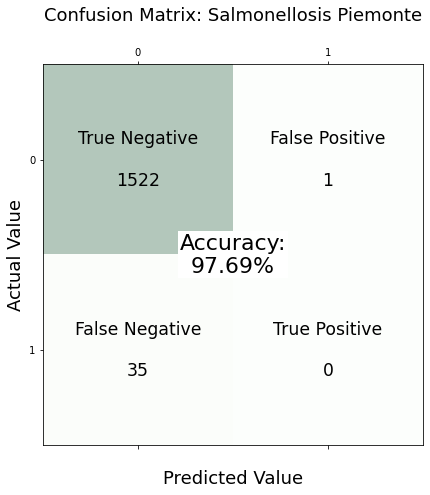

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.special import expit, logit
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

pred_results ={}
case_labels = [['True Negative','False Positive'],['False Negative','True Positive']]

for disease_label in datasets.keys():
    #Make predictions
    with warnings.catch_warnings(record=True):
        pred_results[disease_label] = model[disease_label].predict(np.array(g_coords[disease_label]['coord_test']),  dfs_x_model[disease_label]['X_test'])
    
    y_predictions = pred_results[disease_label].predictions.flatten()
    y_predy = pred_results[disease_label].predy.flatten()
    y_test = dfs_y_model[disease_label]['y_test'].flatten()
    
    '''
    print("test print: prediction prob vs true value")
    for i in range(len(y_predictions)):
        print(str(y_predictions[i]) + " --> " + str(y_test[i]))
    '''
    
    #apply inverse of logit for have probability of esito = 1
    y_score = expit(y_predictions)
    #print(y_score)
    y_pred = np.round(y_score)
    
    acc = accuracy_score(y_test, y_pred)
    acc_str = str(round(acc*100,2)) + '%'
    print("ACCURACY: " + str(acc))
    
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    #cm_display = ConfusionMatrixDisplay(cm).plot()
    
    f1 = f1_score(y_test, y_pred)
    print("F1 score: " + str(f1))
    
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.matshow(cm, cmap=plt.cm.Greens, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_section = case_labels[i][j] + "\n\n" + str(cm[i, j])
            ax.text(x=j, y=i,s=text_section, va='center', ha='center', size='xx-large')
    
    plt.xlabel('\nPredicted Value', fontsize=18)
    plt.ylabel('Actual Value', fontsize=18)
    plt.text(.5,.5, "Accuracy:\n" + acc_str,fontsize=22,
                      bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':2},
                      ha='center', va='center')
    plt.title('Confusion Matrix: ' + disease_label + ' ' + region_code_dict[region] + '\n', fontsize=18)
    plt.show()
    
    #Check if directory exists, if not, create it
    cm_folder = 'graphics/' + region_code_dict[region] + '/confusion_matrix/'
    CHECK_FOLDER = os.path.isdir(cm_folder)
    if not CHECK_FOLDER:
        os.makedirs(cm_folder)
    fig.savefig(cm_folder + region_code_dict[region] + '_' + disease_label + '_' + 'confusion_matrix' + '.png')
    #plt.savefig(cm_folder + region_code_dict[region] + '_' + disease_label + '_' + 'confusion_matrix' +  '.jpg')
    
    #tn, fp, fn, tp = confusion_matrix(y, round_prob_pred).ravel()
    #print("TN: " + str(tn) + " FP: " + str(fp) + " FN: " + str(fn) + " TP: " + str(tp))
    
    #display(pred_results[disease_label].W)
    
    #Check correlation between known and predicted values
    #corr = np.corrcoef(y_predy,y)[0][1]
    #print("CorrCoeff: " + str(corr))

roc_auc:0.6262639527248851


AttributeError: 'RocCurveDisplay' object has no attribute 'savefig'

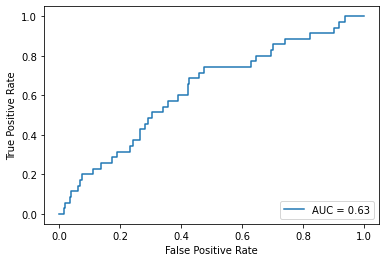

In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics
        
#calculate AUC of model
auc = metrics.roc_auc_score(y_test, y_score)
print("roc_auc:" + str(auc))

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc).plot()

# Residuals

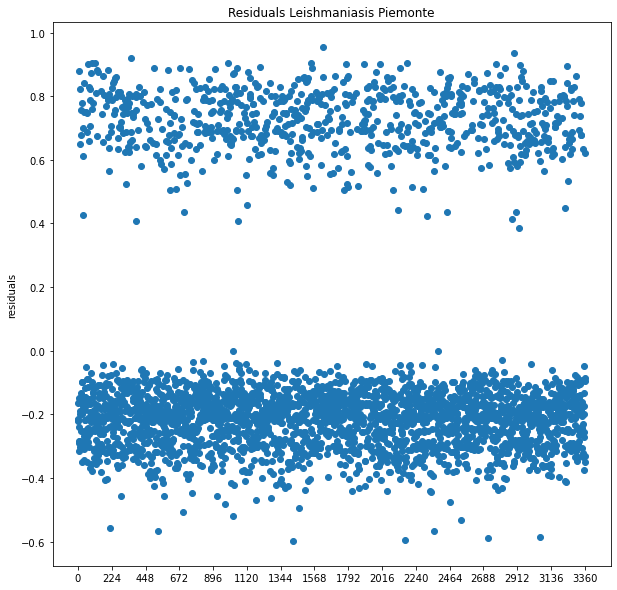

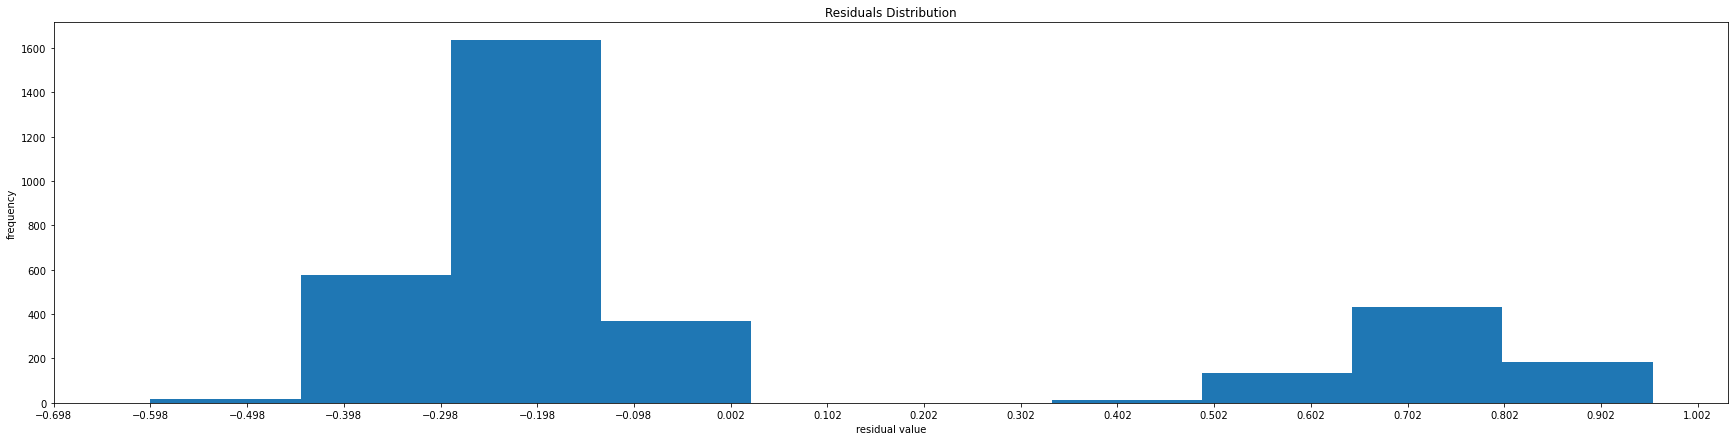

In [ ]:
for disease_label in datasets.keys():
    #Local model fit
    for region in target_regions:
        #print("resid response")
        #print(gwr_results[disease_label].resid_response)
        residuals = gwr_results[disease_label].resid_response
        residuals_len = len(residuals)
        x_interval = int(residuals_len/15)
        min_res = residuals.min()
        #print(min_res)
        max_res = residuals.max()
        #print(max_res)
        
        plt.figure(figsize=(10,10))
        plt.scatter(np.arange(residuals_len), residuals)
        plt.xticks(np.arange(0, residuals_len+1, x_interval))
        plt.ylabel("residuals")
        plt.title("Residuals " + disease_label + " " + region_code_dict[region])
        plt.savefig('graphics/residual_' + region_code_dict[region] + '_' + disease_label)
        plt.show()
        
        #plot of residuals distribution
        plt.figure(figsize=(30,7))
        plt.hist(residuals)
        plt.xticks(np.arange(min_res-0.1, max_res+0.1, 0.1))
        plt.ylabel('frequency')
        plt.xlabel('residual value')
        plt.title('Residuals Distribution')
        plt.savefig('graphics/residual_distribution_' + region_code_dict[region] + '_' + disease_label)
        plt.show()       

# Regression estimates

Intepreting GWRs often involves building maps of the regression estimates. However, we only want to interpret estimates for statistically significant parameters. The mgwr package has implemented methods to extract a “filtered” set of local estimates based on a significance threshold (α) that sets all non-significant results at each site to zero. Thus, the filter_tvals method returns an N × P matrix of the significant local coefficient estimates and is zero when these estimates are not statistically significant at the alpha significance level:

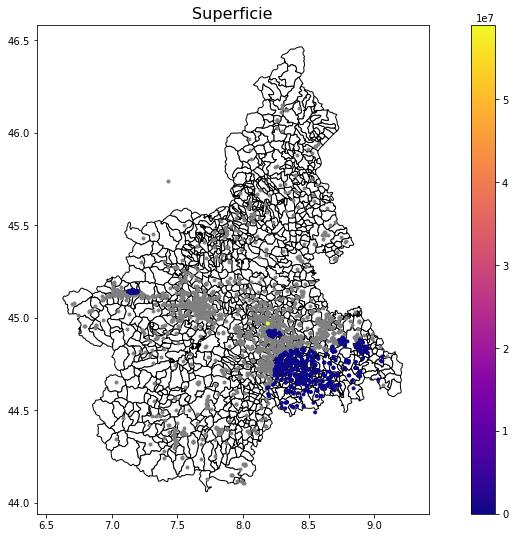

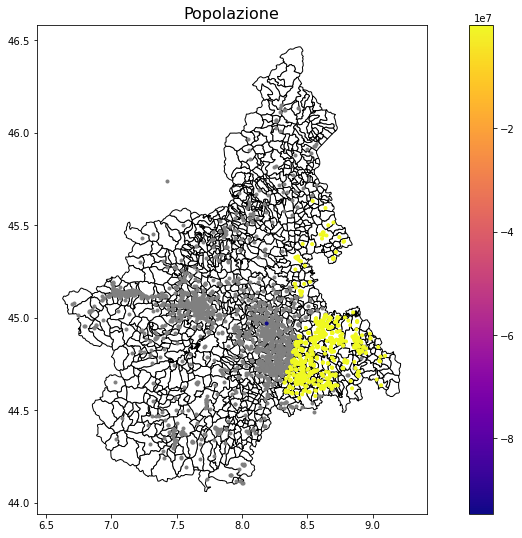

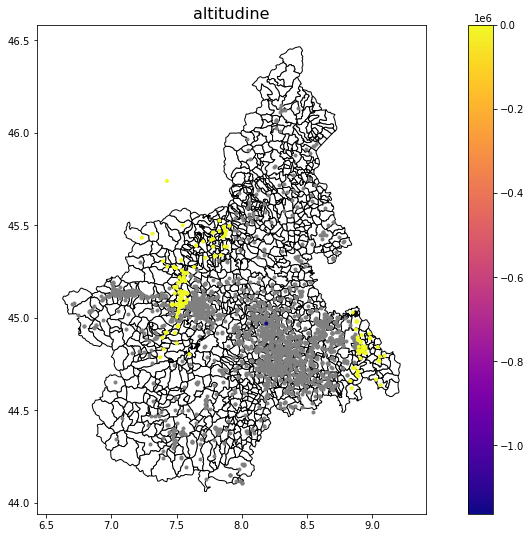

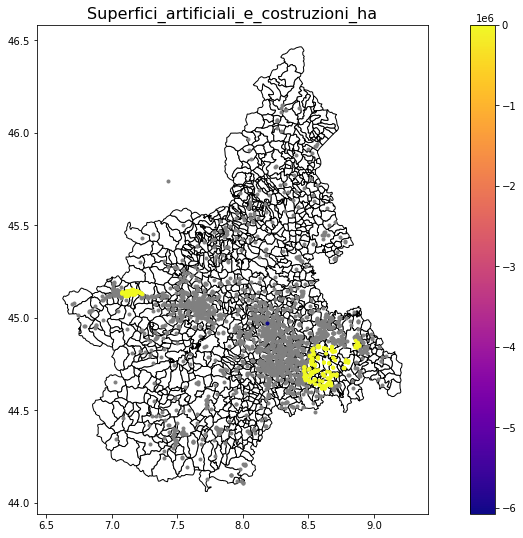

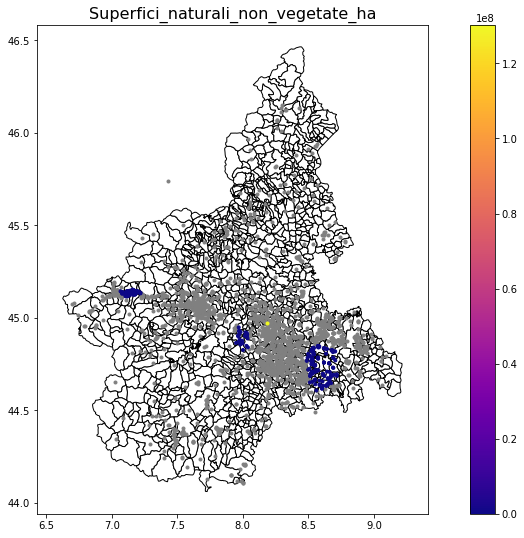

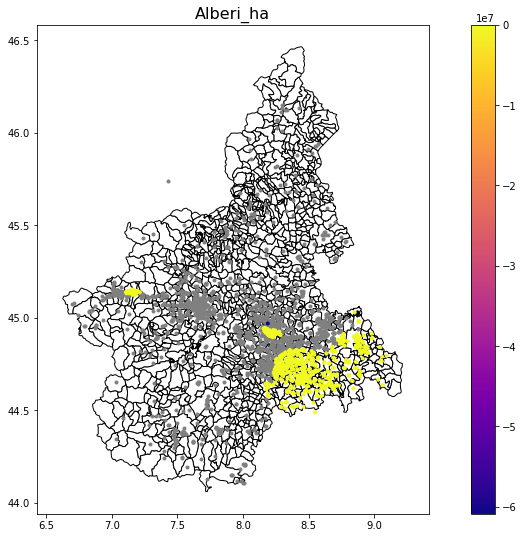

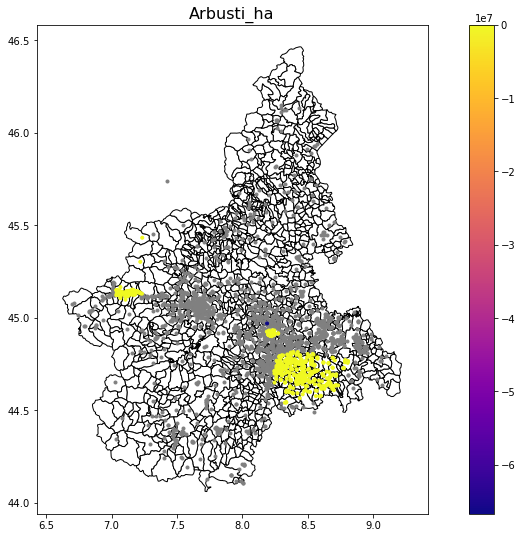

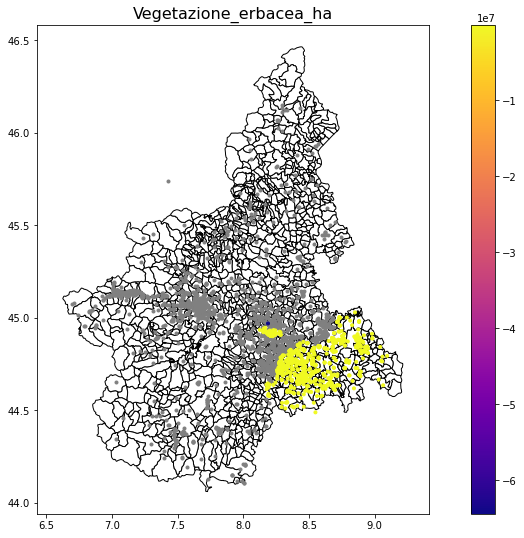

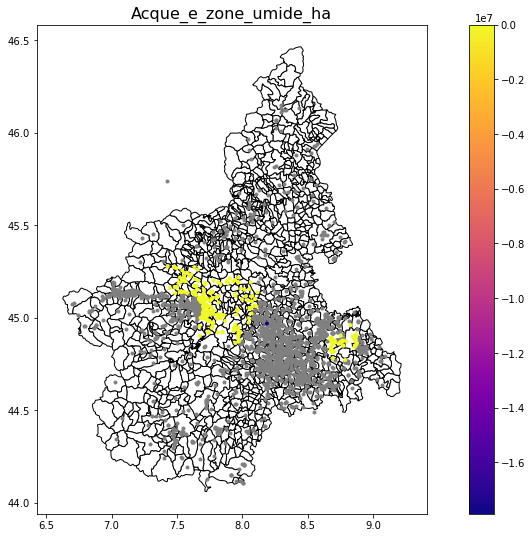

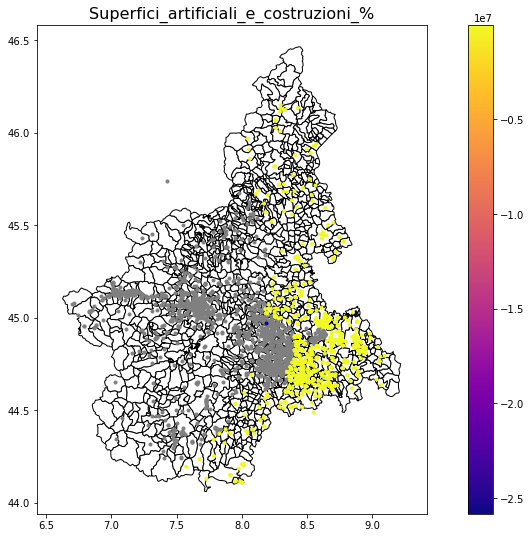

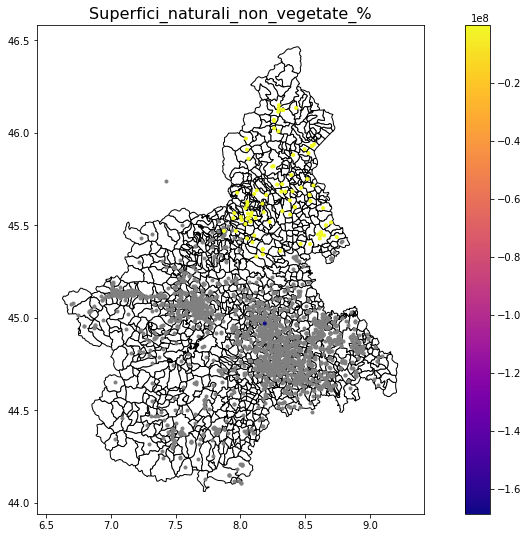

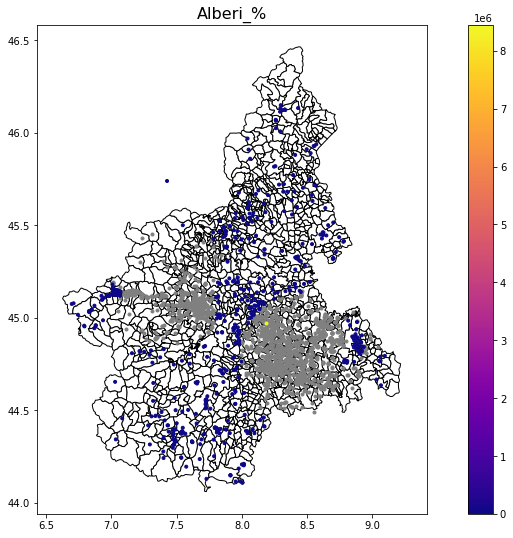

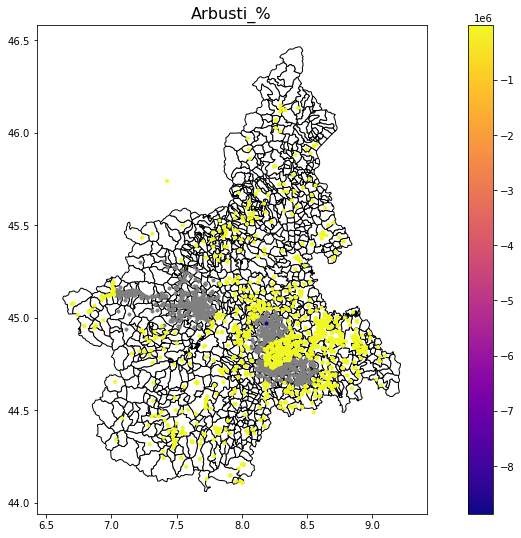

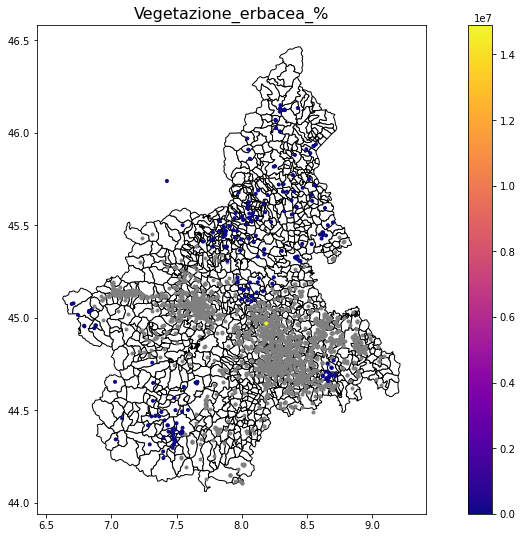

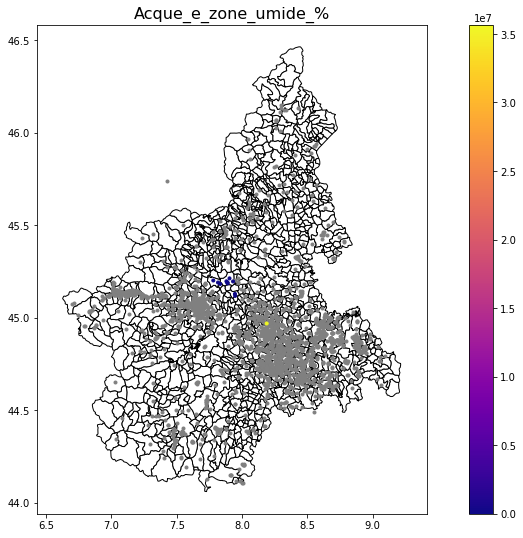

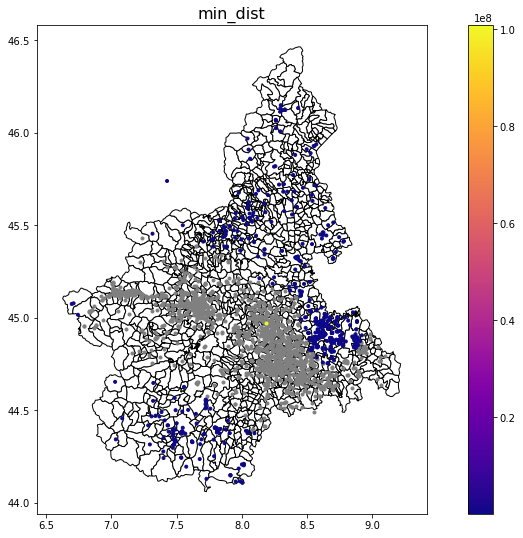

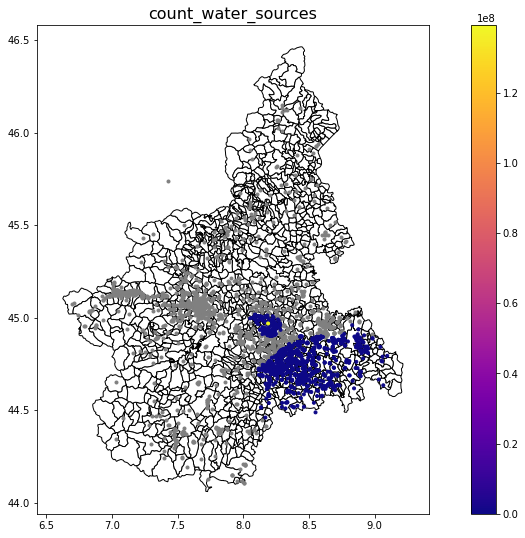

In [ ]:
filtered_estimates = {}
for disease_label in datasets.keys():
    #Local model fit
    for region in target_regions:
        with warnings.catch_warnings(record=True):
            #print("resid response")
            #print(gwr_results[disease_label].resid_response)
            filtered_estimates[disease_label] = gwr_results[disease_label].filter_tvals(alpha=.05)
            
            #we'll work on each of the covariates. For each one:
            for i,row in enumerate(filtered_estimates[disease_label].T):
                #print(filtered_estimates[disease_label].T)
                fig, ax = plt.subplots(figsize = (15, 9))
                
                gdf_region_municipalities.plot(ax=ax, **{'edgecolor': 'black', 'facecolor': 'white'})
                
                disease_coord = g_coords[disease_label]['coord_train']
                gdf_geometry = gp.GeoDataFrame(
                                disease_coord, crs={'init': 'epsg:4326'},
                                geometry=[Point(coord[0], coord[1]) for coord in disease_coord])
                #make a new column in the central_listings dataframe
                toplot_tmp = gdf_geometry.assign(toplot = row)
                
                #set title of the plot to be the name of the variable:
                plt.title(features_columns[i],fontsize=16)
                region_bound= gdf_region_municipalities.total_bounds
                plt.xlim([region_bound[0]-0.2, region_bound[2]+0.2])
                
                #plot all the non-significant estimates in a slightly-transparent grey
                not_significant_feature = toplot_tmp.query('toplot == 0.0')
                if len(not_significant_feature)>0:
                    not_significant_feature.sort_values('toplot').plot(color='grey', ax=ax, alpha=1, marker='.')
                
                #and plot alle the significant estimates in color
                significant_feature = toplot_tmp.query('toplot != 0.0')
                if len(significant_feature)>0:
                    significant_feature.sort_values('toplot').plot('toplot', cmap='plasma', ax=ax, legend=True, marker='.')
                
                #Check if directory exists, if not, create it
                CHECK_FOLDER = os.path.isdir('graphics/' + region_code_dict[region])
                if not CHECK_FOLDER:
                    os.makedirs('graphics/' + region_code_dict[region])
                plt.savefig('graphics/' + region_code_dict[region] + '/' + region_code_dict[region] + '_' + features_columns[i] + '_' + disease_label )
                
                plt.show()


In [ ]:
#this is for print some rows of water dataframe with calculated new features for thesis
from shapely import wkt

region = 'Piemonte'
disease = 'leishmania'
folder_distance = "distances"
distance_to_water_file = folder_distance + "/" + region + "_" + disease + "_" + "water_dist"
df_water = pd.read_feather(distance_to_water_file)
display(df_water.head(10))
#wl= df_water.iloc[1000]['geometry']
#print(wl)
#display(wkt.loads(str(wl)))

pt_address_idx  water_i   index     osm_id osm_type waterway  \
0               0    13491   13491  167441213      way    river   
1               0   122916  122916       None     None     None   
2               0   122915  122915       None     None     None   
3               0   122914  122914       None     None     None   
4               0   122872  122872       None     None     None   
5               0   122913  122913       None     None     None   
6               0   122873  122873       None     None     None   
7               0   122912  122912       None     None     None   
8               0   122874  122874       None     None     None   
9               0   116723  116723       None     None     None   

            name  osm_id_2 osm_type_2 amenity         name_2  \
0  Torrente Erro      None       None    None           None   
1           None  76785867        way    None  Fiume Bormida   
2           None  76785867        way    None  Fiume Bormida   
3           None  76785867        way    None  Fiume Bormida   
4           None  76785867        way    None  Fiume Bormida   
5           None  76785867        way    None  Fiume Bormida   
6           None  76785867        way    None  Fiume Bormida   
7           None  76785867        way    None  Fiume Bormida   
8           None  76785867        way    None  Fiume Bormida   
9           None  58235311        way    None  Fiume Bormida   

                                            geometry  \
0  b'\x01\x05\x00\x00\x00\x03\x00\x00\x00\x01\x02...   
1  b'\x01\x05\x00\x00\x00\x01\x00\x00\x00\x01\x02...   
2  b'\x01\x05\x00\x00\x00\x01\x00\x00\x00\x01\x02...   
3  b'\x01\x05\x00\x00\x00\x01\x00\x00\x00\x01\x02...   
4  b"\x01\x05\x00\x00\x00\x01\x00\x00\x00\x01\x02...   
5  b'\x01\x05\x00\x00\x00\x01\x00\x00\x00\x01\x02...   
6  b"\x01\x05\x00\x00\x00\x01\x00\x00\x00\x01\x02...   
7  b'\x01\x05\x00\x00\x00\x01\x00\x00\x00\x01\x02...   
8  b'\x01\x05\x00\x00\x00\x01\x00\x00\x00\x01\x02...   
9  b'\x01\x05\x00\x00\x00\x01\x00\x00\x00\x01\x02...   

                                               point  \
0  b'\x01\x01\x00\x00\x00\x15k]\x0f\xcb\xdb @)B\x...   
1  b'\x01\x01\x00\x00\x00\x15k]\x0f\xcb\xdb @)B\x...   
2  b'\x01\x01\x00\x00\x00\x15k]\x0f\xcb\xdb @)B\x...   
3  b'\x01\x01\x00\x00\x00\x15k]\x0f\xcb\xdb @)B\x...   
4  b'\x01\x01\x00\x00\x00\x15k]\x0f\xcb\xdb @)B\x...   
5  b'\x01\x01\x00\x00\x00\x15k]\x0f\xcb\xdb @)B\x...   
6  b'\x01\x01\x00\x00\x00\x15k]\x0f\xcb\xdb @)B\x...   
7  b'\x01\x01\x00\x00\x00\x15k]\x0f\xcb\xdb @)B\x...   
8  b'\x01\x01\x00\x00\x00\x15k]\x0f\xcb\xdb @)B\x...   
9  b'\x01\x01\x00\x00\x00\x15k]\x0f\xcb\xdb @)B\x...   

                          geocode_address  meters_dist  
0  VIALE G.CACCIA 4,15010,TERZO,AL,Italia   730.220015  
1  VIALE G.CACCIA 4,15010,TERZO,AL,Italia  1353.613129  
2  VIALE G.CACCIA 4,15010,TERZO,AL,Italia  1327.958388  
3  VIALE G.CACCIA 4,15010,TERZO,AL,Italia  1301.258424  
4  VIALE G.CACCIA 4,15010,TERZO,AL,Italia  1316.690616  
5  VIALE G.CACCIA 4,15010,TERZO,AL,Italia  1272.236756  
6  VIALE G.CACCIA 4,15010,TERZO,AL,Italia  1283.102448  
7  VIALE G.CACCIA 4,15010,TERZO,AL,Italia  1245.545232  
8  VIALE G.CACCIA 4,15010,TERZO,AL,Italia  1265.937818  
9  VIALE G.CACCIA 4,15010,TERZO,AL,Italia  2474.991213